In [2]:
import pandas as pd
data = pd.read_csv('datasets/insurance.csv')
data[:10]

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
5,31,female,25.740,0,no,southeast,3756.62160
6,46,female,33.440,1,no,southeast,8240.58960
7,37,female,27.740,3,no,northwest,7281.50560
8,37,male,29.830,2,no,northeast,6406.41070
9,60,female,25.840,0,no,northwest,28923.13692


---
检查有无缺失值

In [3]:
data.isnull().any()

age         False
sex         False
bmi         False
children    False
smoker      False
region      False
charges     False
dtype: bool

---
下面查看Age和bmi的分布情况

<BarContainer object of 20 artists>

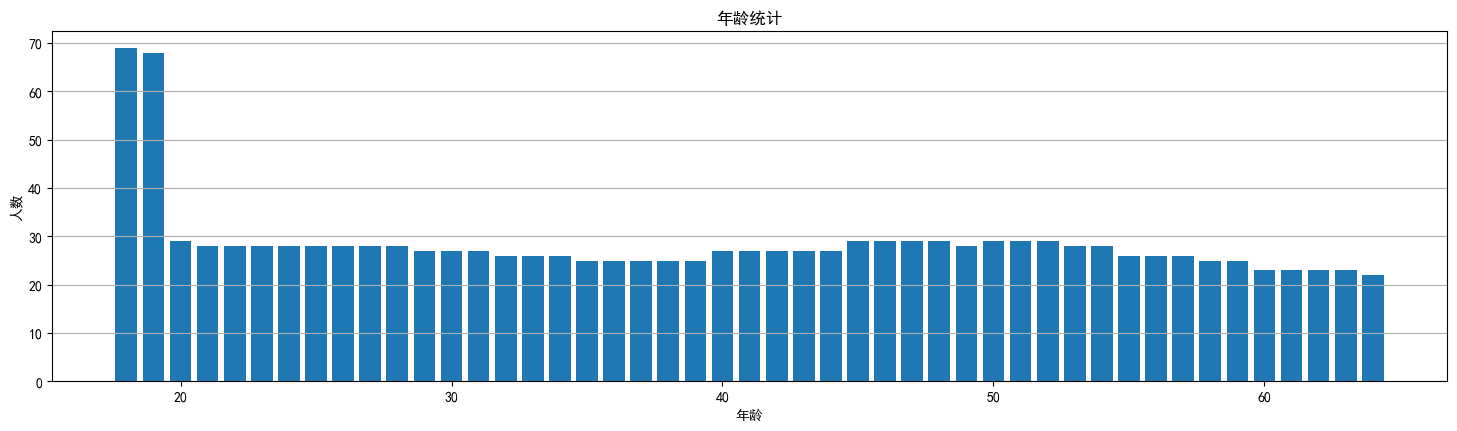

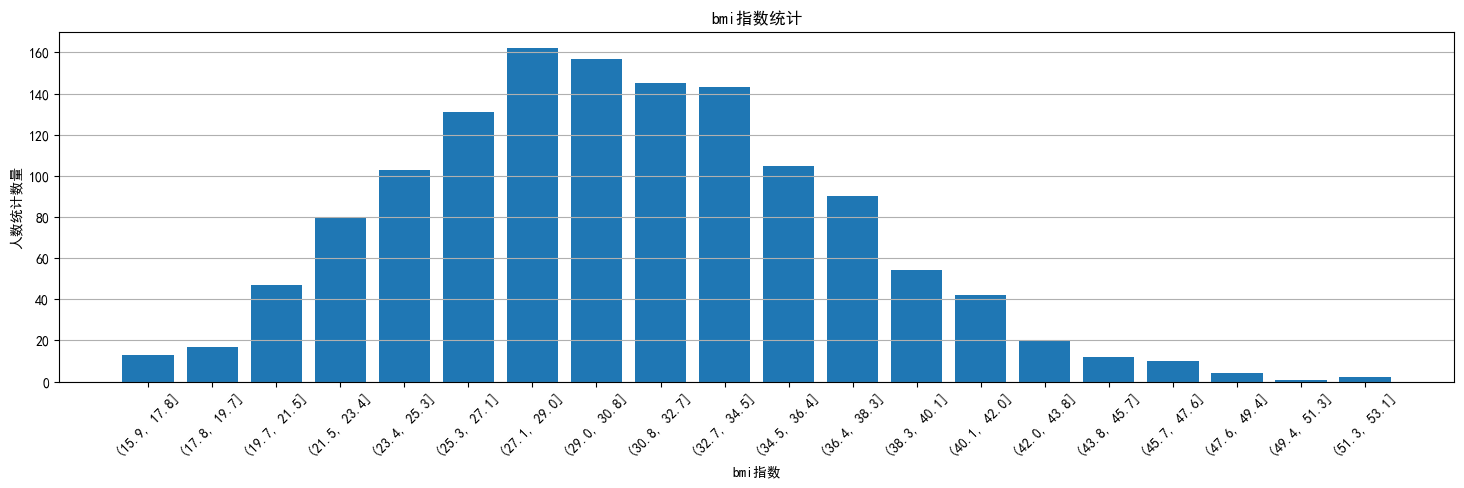

In [4]:
import matplotlib.pyplot as plt
plt.rcParams["font.sans-serif"] = ["SimHei"]

plt.figure(figsize=(18, 10))
plt.subplot(2, 1, 1)
age = data.age.value_counts().sort_index()
plt.grid(axis='y')
plt.title("年龄统计")
plt.xlabel('年龄')
plt.ylabel('人数')
plt.bar(age.index, age.values)

plt.figure(figsize=(18, 10))
plt.subplot(2, 1, 2)
cut = pd.cut(data.bmi.values, bins=20, precision=1).value_counts()
xlabel = cut.index.astype(str)
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.title("bmi指数统计")
plt.xlabel('bmi指数')
plt.ylabel('人数统计数量')
plt.bar(xlabel, cut)

---
处理数据：
&emsp;&emsp;对 `age` 和 `bmi` 采用zscore标准化处理
&emsp;&emsp;对类别型数据 `sex, smoker, region` 采用01编码处理

In [7]:
from tool.preprocessing import Preprocessing
prep = Preprocessing()

# input:    data.columns
# output:   ['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges']

# 数据无量纲化处理
data = data.values
data = prep.zscore(data, [0, 2])
data = prep.OneHotEncoder(data, [1, 4, 5])

# 划分训练集和测试集
X_train, y_train, X_test, y_test = prep.split(data)

In [72]:
import numpy as np
from algorithm.LinearRegression import MiniBGD
from tool.predict import Evaluation

# 模型训练
model_view = []

# 寻找合适参数
for beta in np.linspace(0.01, 1, 30):

    for alpha in np.linspace(0.01, 0.45, 30):

        LR = MiniBGD(alpha=alpha, beta=beta, tol=1e-4, maxiter=1e4)

        # 训练模型
        LR.fit(X_train, y_train)

        # 评估模型
        pred = Evaluation(X_test, LR.theta, y_test)
        model_view.append([alpha, beta, LR.loss[-1], pred.R2()])
model_view = pd.DataFrame(model_view, columns=['alpha', 'beta', 'loss', 'R2'])

# 不同alpha和beta取值下的模型的均方误差和决定系数
model_view

,alpha,beta,loss,R2
0,0.010000,0.01,3.784465e+07,0.647747
1,0.025172,0.01,3.784481e+07,0.647794
2,0.040345,0.01,3.784481e+07,0.647794
3,0.055517,0.01,3.784481e+07,0.647794
4,0.070690,0.01,3.784481e+07,0.647794
...,...,...,...,...
895,0.389310,1.00,3.783044e+07,0.638454
896,0.404483,1.00,3.783044e+07,0.638454
897,0.419655,1.00,3.783044e+07,0.638454
898,0.434828,1.00,3.783044e+07,0.638454


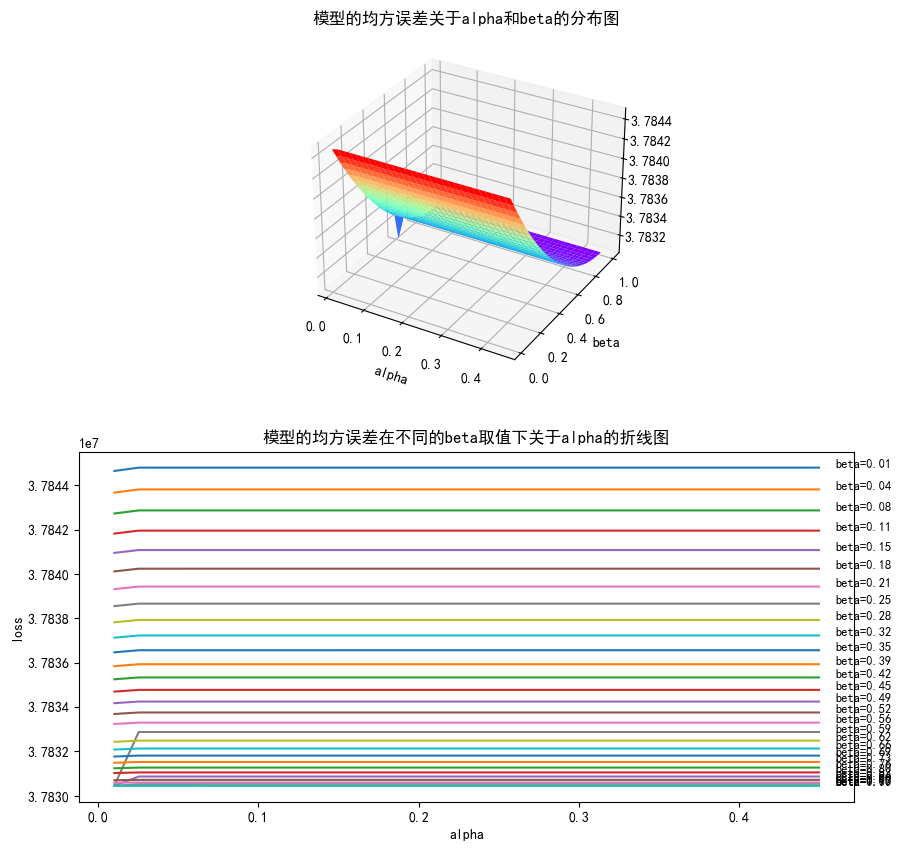

In [76]:
x = np.linspace(0.01, 0.45, 30)
y = np.linspace(0.01, 1, 30)
X, Y = np.meshgrid(x, y)
loss = np.array(model_view.loss.values).reshape(30, 30)
fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(211, projection='3d')
ax1.plot_surface(X, Y, loss, cmap='rainbow')
ax1.set_xlabel('alpha')
ax1.set_ylabel('beta')
ax1.title.set_text('模型的均方误差关于alpha和beta的分布图')

ax2 = fig.add_subplot(212)
for i in loss:
    s = 'beta=%0.2f' % np.linspace(0.01, 1, 30)[loss.tolist().index(i.tolist())]
    ax2.text(x[-1] + 0.01, i[-1], s=s, fontsize=9)
    ax2.set_xlabel('alpha')
    ax2.set_ylabel('loss')
    ax2.title.set_text('模型的均方误差在不同的beta取值下关于alpha的折线图')
    ax2.plot(x, i)

plt.show()

在设定的范围内，beta取值越大，模型均方误差越小，在图二中，均方误差在beta趋于1时收敛，<br>
而alpha取值影响较小，不过合理范围内，alpha取值越大，模型训练速度越快，所以，<br>
最终模型参数alpha取值为0.4, beta取值为1<br>